# NERC region maps
NERC shapefiles are from *Tamayao, M.-A. M., Michalek, J. J., Hendrickson, C. & Azevedo, I. M. L. Regional Variability and Uncertainty of Electric Vehicle Life Cycle CO2 Emissions across the United States. Environ. Sci. Technol. 49, 8844–8855 (2015)*.


This notebook should be run after the `Paper figures` notebook. The index summary table used here is calculated at the end of that notebook.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import os
from os.path import join
import pandas as pd
import sys


sns.set(style='white')
cwd = os.getcwd()
data_path = join(cwd, '..', 'Data storage')
figure_path = join(cwd,'..', 'Figures')
file_date = '2018-03-06'

In [2]:
%load_ext watermark
%watermark -v -p pandas,geopandas,shapely

CPython 3.6.4
IPython 6.2.1

pandas 0.22.0
geopandas 0.3.0
shapely 1.6.4.post1


In [3]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

In [4]:
# add the 'src' directory as one where we can import modules
src_dir = join(cwd, os.pardir, 'src')
sys.path.append(src_dir)

In [5]:
%aimport Plots.plot
from Plots.plot import plot_nerc_annual

## Read NERC regions shapefile

In [6]:
path = os.path.join(data_path, 'nercregions', 'NERCregions.shp')
regions_nerc = gpd.read_file(path)
regions_nerc['nerc'] = regions_nerc['NERCregion']

In [7]:
regions_nerc

,OBJECTID,NERCregion,SHAPE_Leng,SHAPE_Area,geometry,nerc
0,1,FRCC,22.488030,11.459289,POLYGON ((-84.86300370899994 30.71266453000004...,FRCC
1,2,MRO,76.997961,130.425939,"POLYGON ((-94.8320392469999 49.33080593000005,...",MRO
2,3,NPCC,48.574281,32.754394,(POLYGON ((-72.5509712409999 40.96617993100006...,NPCC
3,4,RFC,99.332877,71.157869,(POLYGON ((-87.92640864299995 44.5391396020000...,RFC
4,5,SERC,128.958444,142.139208,POLYGON ((-80.20680177299994 36.54903791300006...,SERC
5,6,SPP,61.523164,56.496471,POLYGON ((-97.56098691099993 36.38533196100008...,SPP
6,7,TRE,44.145641,50.605118,POLYGON ((-104.4498774409999 32.00686615000006...,TRE
7,8,WECC,102.110211,323.227276,(POLYGON ((-122.6656125679999 48.3967777520000...,WECC


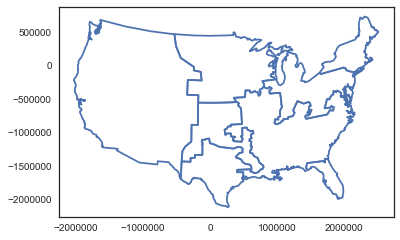

In [8]:
regions_nerc.to_crs(epsg=2163).boundary.plot()

## Read states shapefile

In [9]:
path = os.path.join(data_path, 'cb_2016_us_state_20m', 'cb_2016_us_state_20m.shp')
states = gpd.read_file(path)
states.crs

{'init': 'epsg:4269'}

In [10]:
drop_states = ['Alaska', 'Hawaii', 'Puerto Rico']
states = states.loc[~states['NAME'].isin(drop_states)]

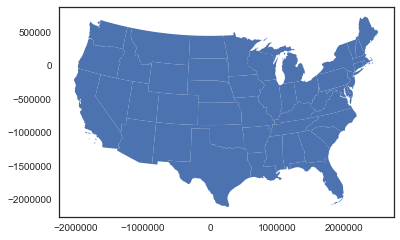

In [11]:
states.to_crs(epsg=2163).plot()

In [12]:
path = join(data_path, 'final NERC data',
            'Summary table {}.csv'.format(file_date))
index = pd.read_csv(path, index_col='nerc')
index

,2001,2017,Reduction,Percent Reduction,Annual Reduction
nerc,,,,,
TRE,609.537529,439.289665,170.247864,0.279307,10.640492
WECC,520.591372,346.313227,174.278145,0.334770,10.892384
USA,630.015064,438.652664,191.362400,0.303743,11.960150
SERC,633.312208,425.263073,208.049135,0.328510,13.003071
RFC,675.979943,461.569398,214.410546,0.317185,13.400659
FRCC,647.751776,410.050361,237.701415,0.366964,14.856338
NPCC,414.615688,172.799260,241.816428,0.583230,15.113527
MRO,854.369109,545.642751,308.726358,0.361350,19.295397
SPP,854.155315,491.243974,362.911341,0.424877,22.681959


In [13]:
index.loc['USA', '2001']

630.0150637090508

In [14]:
# Add 2001, 2017, and % reduction values from summary table to geodataframe
for nerc in regions_nerc['nerc'].unique():
    try:
        val_2017 = index.loc[nerc, '2017']
        val_2001 = index.loc[nerc, '2001']
        reduce = index.loc[nerc, 'Percent Reduction']
        regions_nerc.loc[regions_nerc['nerc']==nerc, 2017] = val_2017
        regions_nerc.loc[regions_nerc['nerc']==nerc, 2001] = val_2001
        
        regions_nerc.loc[regions_nerc['nerc']==nerc, 'reduction'] = '{:.0%}'.format(reduce)
        regions_nerc.loc[regions_nerc['nerc']==nerc, 'reduction value'] = reduce
    except:
        pass

# Define national parameters for use in plot titles
usa_2001 = index.loc['USA', '2001']
usa_2017 = index.loc['USA', '2017']

In [15]:
regions_nerc

,OBJECTID,NERCregion,SHAPE_Leng,SHAPE_Area,geometry,nerc,2017,2001,reduction,reduction value
0,1,FRCC,22.488030,11.459289,POLYGON ((-84.86300370899994 30.71266453000004...,FRCC,410.050361,647.751776,37%,0.366964
1,2,MRO,76.997961,130.425939,"POLYGON ((-94.8320392469999 49.33080593000005,...",MRO,545.642751,854.369109,36%,0.361350
2,3,NPCC,48.574281,32.754394,(POLYGON ((-72.5509712409999 40.96617993100006...,NPCC,172.799260,414.615688,58%,0.583230
3,4,RFC,99.332877,71.157869,(POLYGON ((-87.92640864299995 44.5391396020000...,RFC,461.569398,675.979943,32%,0.317185
4,5,SERC,128.958444,142.139208,POLYGON ((-80.20680177299994 36.54903791300006...,SERC,425.263073,633.312208,33%,0.328510
5,6,SPP,61.523164,56.496471,POLYGON ((-97.56098691099993 36.38533196100008...,SPP,491.243974,854.155315,42%,0.424877
6,7,TRE,44.145641,50.605118,POLYGON ((-104.4498774409999 32.00686615000006...,TRE,439.289665,609.537529,28%,0.279307
7,8,WECC,102.110211,323.227276,(POLYGON ((-122.6656125679999 48.3967777520000...,WECC,346.313227,520.591372,33%,0.334770


### Transform projection to Albers equal area

In [71]:
regions_albers = regions_nerc.to_crs(epsg=2163)
states_albers = states.to_crs(epsg=2163)

### Maps of 2001 and 2017 annual values

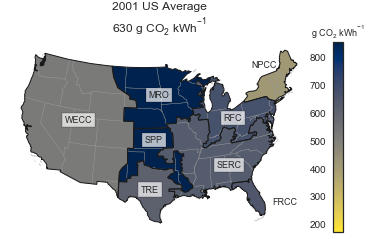

In [42]:
title = '2001 US Average\n{:.0f} g $\mathregular{{CO_2 \ kWh^{{-1}}}}$'.format(usa_2001)
kwargs = dict(
    regions_lw = 1,
    regions_ec = '0.1',
    SERC_y = -1.5,
    SPP_y = 2.25
)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2001,
                 text_col='nerc', vmin=vmin, vmax=vmax, title=title,
                 cbar_title='g $\mathregular{CO_2 \ kWh^{-1}}$', **kwargs)

path = join(figure_path, 'NERC map_cividis_2001.pdf')
plt.savefig(path, bbox_inches='tight')#, dpi=350)

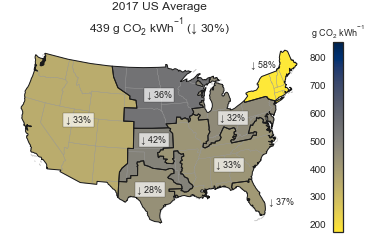

In [43]:
title = '2017 US Average\n{:.0f} g $\mathregular{{CO_2 \ kWh^{{-1}}}}$ (↓ 30%)'.format(usa_2017)
kwargs = dict(
    regions_lw = 1,
    regions_ec = '0.1',
    SERC_y = -1.5,
    SPP_y = 2.25,
    FRCC_x = 4.3
)

vmin = regions_albers.loc[:, [2001, 2017]].min().min()
vmax = regions_albers.loc[:, [2001, 2017]].max().max()
regions_albers['arrow reduction'] = '↓ ' + regions_albers['reduction']
plot_nerc_annual(regions_proj=regions_albers, states_proj=states_albers, data_col=2017,
                 text_col='arrow reduction', vmin=vmin, vmax=vmax, title=title,
                 cbar_title='g $\mathregular{CO_2 \ kWh^{-1}}$', **kwargs)
path = join(figure_path, 'NERC map_cividis_2017_change.pdf')
plt.savefig(path, bbox_inches='tight')#, dpi=350)